# Goal : Predict the Sentiments of Tweets

# The Workflow

- Import Files & Modules
- Process Data
- Exploratory Data Analysis
- Modeling (Senetence Transformers)
- Explainabilty (Using Lime)


# A. Import Files & Modules

In [50]:
# Get all filenames
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/twitter-entity-sentiment-analysis/twitter_validation.csv
/kaggle/input/twitter-entity-sentiment-analysis/twitter_training.csv


In [14]:
!pip install vaderSentiment

In [51]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sentence_transformers import SentenceTransformer
from sentence_transformers.losses import CosineSimilarityLoss

from xgboost import XGBClassifier
from sklearn.metrics import classification_report

from sklearn.pipeline import make_pipeline
from lime.lime_text import LimeTextExplainer
from sklearn.model_selection import GridSearchCV
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer


# B. Process Data
Concatenate Data for EDA

In [54]:
train = pd.read_csv("/kaggle/input/twitter-entity-sentiment-analysis/twitter_training.csv", header=None)
train.rename(columns={0: 'tweet_id', 1: 'entity', 2: 'sentiment', 3: 'tweet'}, inplace=True)
train.dropna(inplace=True)  # Corrected: remove NA values
train.reset_index(drop=True, inplace=True)  # Corrected: reset index after dropna
train['sentiment_label'] = train['sentiment'].astype('category').cat.codes

In [ ]:
val = pd.read_csv("/kaggle/input/twitter-entity-sentiment-analysis/twitter_validation.csv", header=None)
val.rename(columns={0: 'tweet_id', 1: 'entity', 2: 'sentiment', 3: 'tweet'}, inplace=True)
val.dropna(inplace=True)  # Corrected: remove NA values
val.reset_index(drop=True, inplace=True)  # Corrected: reset index after dropna
val['sentiment_label'] = val['sentiment'].astype('category').cat.code

# Initializing VADER analyzer

In [ ]:
analyzer = SentimentIntensityAnalyzer()

Function to calculate sentiment scores

In [ ]:
def sentiment_scores(sentence):
    score = analyzer.polarity_scores(sentence)
    return score['compound']

 Applying sentiment intensity scoring to training and validation data

In [29]:
train['sentiment_intensity'] = train['tweet'].apply(sentiment_scores)
val['sentiment_intensity'] = val['tweet'].apply(sentiment_scores)

In [55]:
print('Sentiment Intensity in Train:', 'sentiment_intensity' in train.columns)
print('Sentiment Intensity in Val:', 'sentiment_intensity' in val.columns)


Sentiment Intensity in Train: True
Sentiment Intensity in Val: True


# C. EDA

## 1. Sentiment Distribution among all tweets
* Most common Sentiment among all tweets?

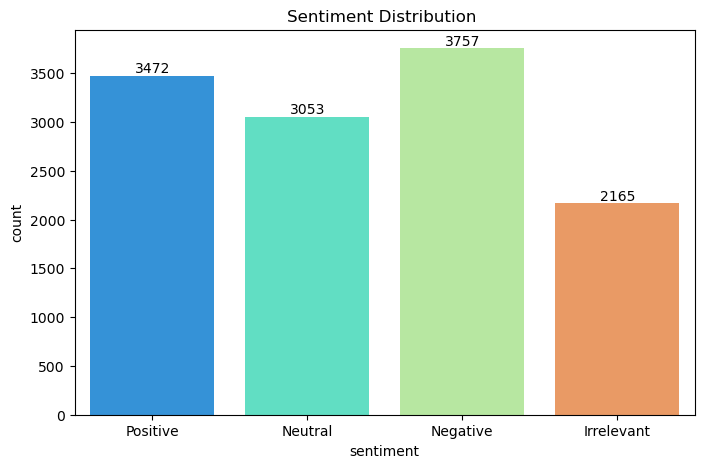

In [31]:
plt.figure(figsize=(8,5))
ax = sns.countplot(x='sentiment',data=df, palette='rainbow')
plt.title("Sentiment Distribution ")

for container in ax.containers:
    ax.bar_label(container)
    

## 2. Entity Distribution among all tweets


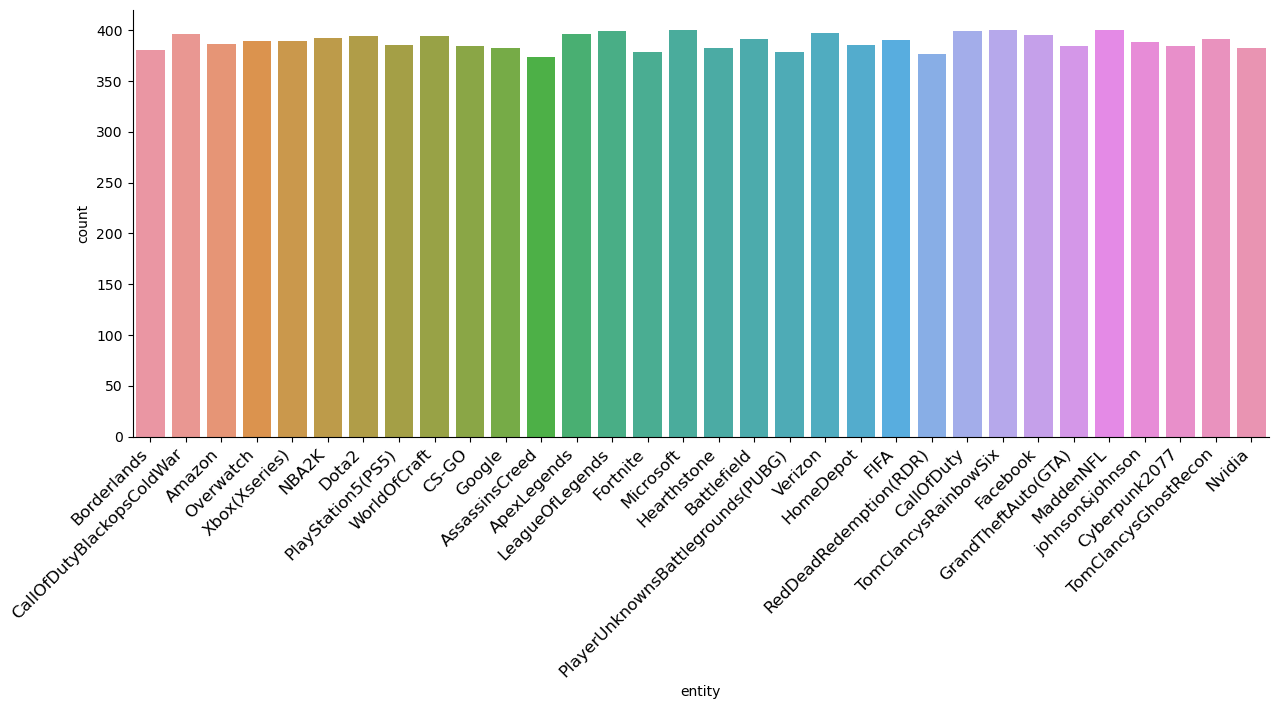

In [32]:
ax = sns.catplot(data=df, x="entity", kind="count", aspect=2.5)
a = plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontsize='large'  
)

## 3. Top 10 Topics

In [33]:
topics = pd.DataFrame({'# of Tweets':df.entity.value_counts()}).head(10)
topics

,# of Tweets
TomClancysRainbowSix,400
MaddenNFL,400
Microsoft,400
LeagueOfLegends,399
CallOfDuty,399
Verizon,397
CallOfDutyBlackopsColdWar,396
ApexLegends,396
Facebook,395
WorldOfCraft,394


**Games** and **Social Media** are topics most discussed in this dataset

## 4. Most common Tweet Sentiment (Topic Wise)

In [34]:
most_common_sentiment = []
for i in topics.index:
    most_common_sentiment.append(df[df.entity==i]['sentiment'].value_counts().idxmax())

In [35]:
topics = pd.DataFrame({'# of Tweets':df.entity.value_counts().head(10), 'Most Common Sentiment': most_common_sentiment}).head(10)
topics = topics.reset_index().rename(columns={'index':'entity'}) 
topics

,entity,# of Tweets,Most Common Sentiment
0,TomClancysRainbowSix,400,Negative
1,MaddenNFL,400,Negative
2,Microsoft,400,Neutral
3,LeagueOfLegends,399,Neutral
4,CallOfDuty,399,Negative
5,Verizon,397,Negative
6,CallOfDutyBlackopsColdWar,396,Positive
7,ApexLegends,396,Neutral
8,Facebook,395,Neutral
9,WorldOfCraft,394,Neutral


# D. Modeling - Using a Sentence Transformer 

In [36]:
model = SentenceTransformer('paraphrase-mpnet-base-v2')

## 1. Train embeddings

In [56]:
train_embeddings = model.encode(train['tweet'], show_progress_bar=True)

Batches:   0%|          | 0/2313 [00:00<?, ?it/s]

In [58]:
train_embeddings_dataframe = pd.DataFrame(train_embeddings)
train_embeddings_dataframe['sentiment_intensity'] = train['sentiment_intensity']
train_embeddings_dataframe['tweet_id'] = train['tweet_id']
train_embeddings_dataframe

,0,1,2,3,4,5,6,7,8,9,...,760,761,762,763,764,765,766,767,sentiment_intensity,tweet_id
0,-0.080680,0.264899,-0.024017,0.076850,0.015520,0.122555,-0.095483,-0.033121,0.162454,-0.045062,...,-0.045632,0.268792,0.007258,-0.088266,0.025679,0.040617,-0.048710,0.071230,-0.6908,2401
1,-0.026836,0.335886,-0.031801,-0.016197,0.024442,-0.071539,-0.096867,-0.146309,0.130576,0.089647,...,0.154689,0.306593,-0.015326,-0.282650,0.043093,0.050344,-0.119437,0.044780,-0.6908,2401
2,-0.094288,0.224658,-0.036972,0.114742,0.023220,0.115769,-0.118356,-0.012362,0.178245,-0.039316,...,-0.018777,0.273062,0.011526,-0.065648,0.027089,0.026725,-0.004247,0.066576,-0.6908,2401
3,-0.050768,0.326308,-0.060233,-0.012294,0.004829,0.046614,-0.122134,-0.042190,0.099051,-0.029460,...,-0.005980,0.259281,-0.043422,-0.192051,0.036036,0.062947,-0.088446,0.060154,-0.6908,2401
4,-0.083012,0.218096,-0.021555,0.096835,-0.049292,0.118272,-0.121902,0.001850,0.144416,-0.058734,...,-0.071094,0.238496,-0.005847,-0.103541,0.051470,0.001429,0.000980,0.052124,-0.6908,2401
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73991,-0.033092,0.046415,-0.059873,0.145822,-0.004290,0.165440,0.046420,0.059832,0.182071,0.010023,...,0.012021,0.004416,-0.098620,0.065441,-0.072640,-0.089525,-0.073766,0.004980,0.0772,9200
73992,-0.031224,0.108450,-0.041004,0.080629,-0.021425,0.105696,0.057308,0.088942,0.194125,0.017257,...,-0.012156,-0.020678,-0.101240,0.063553,-0.057631,-0.064718,-0.103607,0.025926,-0.2960,9200
73993,0.010497,0.131395,-0.072493,0.143362,-0.018099,0.110841,0.131154,0.120018,0.187008,-0.033768,...,0.007241,-0.030044,-0.080805,0.068095,0.003532,-0.086116,-0.111204,-0.041602,-0.2960,9200
73994,-0.086434,0.074805,-0.037073,0.150816,0.024772,0.209441,0.075488,0.053197,0.115812,0.019700,...,0.000988,-0.057820,-0.049101,0.051786,-0.067421,-0.027325,-0.065883,-0.046491,0.0772,9200


In [61]:
train_embeddings_dataframe.to_csv("train_embeddings.csv", index=False)

## 2. Validation embeddings

In [42]:
val_embeddings = model.encode(val['tweet'], show_progress_bar=True)

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

In [59]:
val_embeddings_dataframe = pd.DataFrame(val_embeddings)
val_embeddings_dataframe['sentiment_intensity'] = val['sentiment_intensity']
val_embeddings_dataframe['tweet_id'] = val['tweet_id']
val_embeddings_dataframe

,0,1,2,3,4,5,6,7,8,9,...,760,761,762,763,764,765,766,767,sentiment_intensity,tweet_id
0,-0.020404,-0.062216,0.024241,0.040892,0.156861,0.078569,-0.048200,0.109143,0.059052,-0.092057,...,0.081351,0.015247,0.085966,0.111101,0.034966,0.116658,-0.123523,0.112956,0.3182,3364
1,0.034883,-0.050718,0.019535,0.078661,-0.012447,0.018758,0.249286,0.072097,0.260489,-0.119313,...,-0.051152,0.143503,0.048456,-0.107498,-0.127091,0.023632,-0.133031,0.027683,-0.0000,352
2,-0.001131,-0.062295,-0.002359,0.060071,-0.037866,0.072745,0.042750,-0.049502,-0.010051,0.149694,...,0.057645,-0.085639,0.080929,-0.059349,0.080436,-0.034857,-0.137507,-0.093279,-0.1027,8312
3,0.048533,0.193313,-0.052567,0.168313,-0.059134,0.047953,0.158697,-0.126434,0.126750,0.095812,...,-0.199650,-0.101692,0.054386,0.094627,0.136777,0.032435,0.039523,-0.032981,-0.0258,4371
4,0.017647,0.231157,-0.052546,-0.160629,0.012892,0.041635,0.066838,0.008467,0.119060,-0.055001,...,0.005882,0.010569,0.024819,-0.116175,-0.084805,0.103638,-0.134887,-0.103412,0.4157,4433
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-0.108763,0.123177,-0.014582,0.009254,0.172567,-0.057062,-0.055394,0.011889,0.000969,0.095078,...,0.014216,0.090265,0.051676,0.209915,-0.054500,0.072332,-0.129522,-0.013771,0.2462,4891
996,-0.160134,0.174525,-0.031276,0.042150,0.009209,0.038410,-0.061418,-0.057239,0.072786,0.055837,...,-0.153958,-0.127415,-0.000284,-0.035750,0.023247,0.256536,0.019636,-0.082503,0.7865,4359
997,-0.103689,0.179627,-0.064074,-0.067953,-0.054722,0.062181,-0.004116,0.006536,0.112430,0.037770,...,0.053819,0.038655,0.047406,-0.087913,0.016993,-0.050224,-0.083019,0.015316,-0.6771,2652
998,0.011777,-0.017902,-0.039674,0.107715,-0.086345,-0.079246,-0.088214,0.069107,-0.233596,-0.070792,...,0.181124,0.041811,0.014718,0.168693,-0.030035,0.073913,0.006076,-0.170153,0.5719,8069


In [62]:
val_embeddings_dataframe.to_csv("val_embeddings.csv", index=False)

## 3. Classification Head
* Run from Here

In [64]:
train_embeddings_dataframe = pd.read_csv("train_embeddings.csv")
val_embeddings_dataframe = pd.read_csv("val_embeddings.csv")

In [65]:
X_train = train_embeddings_dataframe.drop(['tweet_id'],axis=1)
y_train = train['sentiment_label']

X_val = val_embeddings_dataframe.drop(['tweet_id'],axis=1)
y_val = val['sentiment_label']

In [66]:
classifier = XGBClassifier(tree_method='gpu_hist')
classifier.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=0, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

In [67]:
print(classification_report(y_val, classifier.predict(X_val)))

              precision    recall  f1-score   support

           0       0.93      0.82      0.87       172
           1       0.91      0.94      0.92       266
           2       0.87      0.85      0.86       285
           3       0.85      0.90      0.87       277

    accuracy                           0.88      1000
   macro avg       0.89      0.88      0.88      1000
weighted avg       0.88      0.88      0.88      1000

